In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# numpy
import numpy as np
import pandas as pd

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torch.nn import MSELoss
from torch.nn import CrossEntropyLoss as CEL
from torch.optim import lr_scheduler
import torchLearning
import datetime

# sklearn 
from sklearn.utils import shuffle

In [2]:
#数据预处理
def csv_to_tensor(csvDate):
    df = pd.read_csv(csvDate)
    data = shuffle(df, random_state=29)
    array = np.array(data)
    tensor = torch.tensor(array, dtype=torch.float32)
    return tensor



data = csv_to_tensor(r"C:\Users\Neos\Desktop\data\data_all.csv")

 
#等数据预处理 封装+加载
features = data[: ,:3]
labels_real = data[: ,3:6]
labels_fake = data[: ,6:9]

#dataset_real = TensorDataset(features, labels_real)

#dataset_fake = TensorDataset(features, labels_fake)

features_train = features[0:432,:]
features_test = features[432:,:]
labels_train = labels_real[0:432,:]
labels_test = labels_real[432:,:]

dataset_real_train = TensorDataset(features_train, labels_train)

dataset_real_test = TensorDataset(features_test, labels_test)

dataset_fake = TensorDataset(features, labels_fake)

#一般用torch.utils.data.dataset.random_split来获取训练集与测试集

#train_real, test_real = random_split(dataset_real,[432,108])
#train_real, test_real = random_split(dataset_real,[378,162])
#train_real, test_real = random_split(dataset_real,[270,270])
#train_real, test_real = random_split(dataset_real,[162,378])
#train_real, test_real = random_split(dataset_real,[108,432])


#一个batch里
batchdata_train_real = DataLoader(dataset_real_train, batch_size = 30, shuffle = True, drop_last = False)
batchdata_test_real = DataLoader(dataset_real_test, batch_size = 30, shuffle = True, drop_last = False)

#batchdata_train_real = DataLoader(train_real, batch_size = 30, shuffle = True, drop_last = False)
#batchdata_test_real = DataLoader(test_real, batch_size = 30, shuffle = True, drop_last = False)


batchdata_fake = DataLoader(dataset_fake, batch_size = 30, shuffle = True, drop_last = False)


#确定超参数
lr = 0.001
gamma = 0.9
bs = 30
lr_lambda = lambda epoch: 0.95 ** epoch

In [3]:
#定义神经网络模型
class Model_1(nn.Module):
    def __init__(self, in_features=3, out_features=3):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 24, bias = True)
        #self.normalize1 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(24, 12, bias = True)
        #self.dropout = nn.Dropout(0.1)
        self.output = nn.Linear(12, out_features, bias = True)
         
    def forward(self, x): #神经网络的向前传播
        #定义一个LeakyReLU
        m = nn.LeakyReLU(0.1) 
        
        #z1 = self.normalize1(self.linear1(x))
        z1 = self.linear1(x)
        #p1 = torch.relu(z1)
        p1 = m(z1)
        z2 = self.linear2(p1)
        #p2 = torch.relu(z2)
        p2 = m(z2)
        #p3 = self.dropout(p2)
        yhat = self.output(p2)
        return yhat

In [4]:
#定义神经网络模型
class Model_2(nn.Module):
    def __init__(self, in_features=3, out_features=3):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 24, bias = True)
        #self.normalize1 = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(24, 12, bias = True)
        #self.dropout = nn.Dropout(0.1)
        self.output = nn.Linear(12, out_features, bias = True)
         
    def forward(self, x): #神经网络的向前传播
        #定义一个LeakyReLU
        m = nn.LeakyReLU(0.1) 
        
        #z1 = self.normalize1(self.linear1(x))
        z1 = self.linear1(x)
        #p1 = torch.relu(z1)
        p1 = m(z1)
        z2 = self.linear2(p1)
        #p2 = torch.relu(z2)
        p2 = m(z2)
        #p3 = self.dropout(p2)
        yhat = self.output(p2)
        return yhat

In [5]:
#定义训练函数1，其中包括损失函数，优化算法，梯度下降流程等等
def fit_1(net, batchdata, lr=0.001, epochs=20, gamma =0.9, betas=(0.9, 0.99)):
    
    criterion = MSELoss()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr, betas=betas, eps=1e-08, weight_decay=0, amsgrad=False)

    # 创建学习率调度器
    scheduler = lr_scheduler.LambdaLR(opt, lr_lambda)
    
    lr_l = [lr]
    
    for epoch in range(epochs):
        for x,y in batchdata:
            yhat = net.forward(x)
            loss = criterion(yhat, y)
            loss.backward()
            opt.step()
            #梯度清零两者皆可
            #net.zero_grad()
            opt.zero_grad()
        
        scheduler.step()
        print(loss)

In [6]:
#实例化神经网络
# 设置随机数种子
torch.manual_seed(420)

#用于直接训练real_data
net_1 = Model_1(in_features=3, out_features=3)

#用于先训练fake_data，再训练real_data
net_2 = Model_2(in_features=3, out_features=3)

In [7]:
def mse_cal(data_loader, net):
    """mse计算函数
    
    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MSE计算结果
    """
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    return F.mse_loss(yhat, y)

def rmse_cal(data_loader, net):
    """rmse计算函数
    
    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MSE计算结果
    """
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    mse = F.mse_loss(yhat, y)
    rmse= np.sqrt(mse.detach())
    return rmse

def mae_cal(data_loader, net):
    """mae计算函数
    
    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MAE计算结果
    """
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    mae_loss = nn.L1Loss(reduction = 'mean')
    #mae_loss = nn.L1Loss(reduce = 'mean')
    return mae_loss(yhat, y)

def r2_cal(data_loader, net):
    """mae计算函数
    
    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MAE计算结果
    """
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    SS_res = torch.sum(torch.square(y - yhat))
    SS_tot = torch.sum(torch.square(y - torch.mean(y)))
    r2 = 1 - SS_res / SS_tot
    return r2

def model_train_test(model, 
                     train_data,
                     test_data,
                     num_epochs = 20):
    """模型误差测试函数：
    :param model_l：模型
    :param train_data：训练数据
    :param test_data: 测试数据   
    :param num_epochs：迭代轮数
    :param criterion: 损失函数
    :return：MSE列表
    """  
    # 模型评估指标矩阵
    rmse_train = []
    rmse_test = []
    mse_train = []
    mse_test = []
    mae_train = []
    mae_test = []
    r2_train = []
    r2_test = []
    eva_train = []
    eva_test = []
    # 模型训练过程
    for epochs in range(num_epochs):
        model.train()
        fit_1(net = model,
            batchdata = train_data, 
            epochs = epochs)
        model.eval()
        rmse_train.append(rmse_cal(train_data, model).detach().item())
        rmse_test.append(rmse_cal(test_data, model).detach().item())
        mse_train.append(mse_cal(train_data, model).detach().item())
        mse_test.append(mse_cal(test_data, model).detach().item())
        mae_train.append(mae_cal(train_data, model).detach().item())
        mae_test.append(mae_cal(test_data, model).detach().item())
        r2_train.append(r2_cal(train_data, model).detach().item())
        r2_test.append(r2_cal(test_data, model).detach().item())
    
    eva_train.append(rmse_train)
    eva_train.append(mse_train)
    eva_train.append(mae_train)
    eva_train.append(r2_train)
    
    eva_test.append(rmse_test)
    eva_test.append(mse_test)
    eva_test.append(mae_test)
    eva_test.append(r2_test)
    
    return eva_train,eva_test

In [8]:
#直接用real_data训练net_1
starttime = datetime.datetime.now()

for i in range(150):
    fit_1(net_1, batchdata_train_real, epochs = 20)

endtime = datetime.datetime.now()
print(endtime - starttime)

tensor(14068.8164, grad_fn=<MseLossBackward0>)
tensor(9193.6367, grad_fn=<MseLossBackward0>)
tensor(2643.0322, grad_fn=<MseLossBackward0>)
tensor(835.9948, grad_fn=<MseLossBackward0>)
tensor(329.6689, grad_fn=<MseLossBackward0>)
tensor(434.0562, grad_fn=<MseLossBackward0>)
tensor(435.6886, grad_fn=<MseLossBackward0>)
tensor(250.8882, grad_fn=<MseLossBackward0>)
tensor(230.6475, grad_fn=<MseLossBackward0>)
tensor(213.7863, grad_fn=<MseLossBackward0>)
tensor(291.5678, grad_fn=<MseLossBackward0>)
tensor(201.0342, grad_fn=<MseLossBackward0>)
tensor(196.3666, grad_fn=<MseLossBackward0>)
tensor(256.6268, grad_fn=<MseLossBackward0>)
tensor(216.2728, grad_fn=<MseLossBackward0>)
tensor(151.4477, grad_fn=<MseLossBackward0>)
tensor(272.8775, grad_fn=<MseLossBackward0>)
tensor(141.9084, grad_fn=<MseLossBackward0>)
tensor(97.3335, grad_fn=<MseLossBackward0>)
tensor(131.6148, grad_fn=<MseLossBackward0>)
tensor(110.3586, grad_fn=<MseLossBackward0>)
tensor(57.1496, grad_fn=<MseLossBackward0>)
tensor(6

tensor(11.4466, grad_fn=<MseLossBackward0>)
tensor(14.4270, grad_fn=<MseLossBackward0>)
tensor(14.8427, grad_fn=<MseLossBackward0>)
tensor(22.7440, grad_fn=<MseLossBackward0>)
tensor(24.7348, grad_fn=<MseLossBackward0>)
tensor(27.8486, grad_fn=<MseLossBackward0>)
tensor(26.9699, grad_fn=<MseLossBackward0>)
tensor(18.1263, grad_fn=<MseLossBackward0>)
tensor(16.3228, grad_fn=<MseLossBackward0>)
tensor(19.5804, grad_fn=<MseLossBackward0>)
tensor(17.4960, grad_fn=<MseLossBackward0>)
tensor(13.2965, grad_fn=<MseLossBackward0>)
tensor(34.4205, grad_fn=<MseLossBackward0>)
tensor(19.0256, grad_fn=<MseLossBackward0>)
tensor(8.1222, grad_fn=<MseLossBackward0>)
tensor(26.6351, grad_fn=<MseLossBackward0>)
tensor(58.0320, grad_fn=<MseLossBackward0>)
tensor(6.5588, grad_fn=<MseLossBackward0>)
tensor(20.5302, grad_fn=<MseLossBackward0>)
tensor(12.7532, grad_fn=<MseLossBackward0>)
tensor(11.8319, grad_fn=<MseLossBackward0>)
tensor(19.6395, grad_fn=<MseLossBackward0>)
tensor(45.8247, grad_fn=<MseLossBa

tensor(13.7630, grad_fn=<MseLossBackward0>)
tensor(7.7787, grad_fn=<MseLossBackward0>)
tensor(30.7664, grad_fn=<MseLossBackward0>)
tensor(16.9172, grad_fn=<MseLossBackward0>)
tensor(28.6311, grad_fn=<MseLossBackward0>)
tensor(16.0033, grad_fn=<MseLossBackward0>)
tensor(23.8716, grad_fn=<MseLossBackward0>)
tensor(21.8487, grad_fn=<MseLossBackward0>)
tensor(8.4375, grad_fn=<MseLossBackward0>)
tensor(10.3555, grad_fn=<MseLossBackward0>)
tensor(12.8288, grad_fn=<MseLossBackward0>)
tensor(41.2879, grad_fn=<MseLossBackward0>)
tensor(8.1172, grad_fn=<MseLossBackward0>)
tensor(16.8821, grad_fn=<MseLossBackward0>)
tensor(14.2859, grad_fn=<MseLossBackward0>)
tensor(13.9210, grad_fn=<MseLossBackward0>)
tensor(18.3733, grad_fn=<MseLossBackward0>)
tensor(23.2180, grad_fn=<MseLossBackward0>)
tensor(20.2276, grad_fn=<MseLossBackward0>)
tensor(9.1889, grad_fn=<MseLossBackward0>)
tensor(14.1821, grad_fn=<MseLossBackward0>)
tensor(14.4542, grad_fn=<MseLossBackward0>)
tensor(5.8304, grad_fn=<MseLossBackw

tensor(13.5971, grad_fn=<MseLossBackward0>)
tensor(3.0066, grad_fn=<MseLossBackward0>)
tensor(5.1153, grad_fn=<MseLossBackward0>)
tensor(1.0222, grad_fn=<MseLossBackward0>)
tensor(2.6009, grad_fn=<MseLossBackward0>)
tensor(4.9422, grad_fn=<MseLossBackward0>)
tensor(3.1056, grad_fn=<MseLossBackward0>)
tensor(3.9347, grad_fn=<MseLossBackward0>)
tensor(3.7672, grad_fn=<MseLossBackward0>)
tensor(2.7623, grad_fn=<MseLossBackward0>)
tensor(4.3656, grad_fn=<MseLossBackward0>)
tensor(2.9777, grad_fn=<MseLossBackward0>)
tensor(2.4444, grad_fn=<MseLossBackward0>)
tensor(2.1668, grad_fn=<MseLossBackward0>)
tensor(3.2365, grad_fn=<MseLossBackward0>)
tensor(2.1453, grad_fn=<MseLossBackward0>)
tensor(2.4438, grad_fn=<MseLossBackward0>)
tensor(2.0467, grad_fn=<MseLossBackward0>)
tensor(4.2542, grad_fn=<MseLossBackward0>)
tensor(5.1974, grad_fn=<MseLossBackward0>)
tensor(9.8141, grad_fn=<MseLossBackward0>)
tensor(8.9499, grad_fn=<MseLossBackward0>)
tensor(6.4568, grad_fn=<MseLossBackward0>)
tensor(2.8

tensor(3.3786, grad_fn=<MseLossBackward0>)
tensor(5.2850, grad_fn=<MseLossBackward0>)
tensor(6.7828, grad_fn=<MseLossBackward0>)
tensor(6.7212, grad_fn=<MseLossBackward0>)
tensor(7.0941, grad_fn=<MseLossBackward0>)
tensor(3.0827, grad_fn=<MseLossBackward0>)
tensor(4.0428, grad_fn=<MseLossBackward0>)
tensor(7.3246, grad_fn=<MseLossBackward0>)
tensor(2.9305, grad_fn=<MseLossBackward0>)
tensor(1.5139, grad_fn=<MseLossBackward0>)
tensor(0.3175, grad_fn=<MseLossBackward0>)
tensor(1.5195, grad_fn=<MseLossBackward0>)
tensor(0.5086, grad_fn=<MseLossBackward0>)
tensor(0.6584, grad_fn=<MseLossBackward0>)
tensor(0.2458, grad_fn=<MseLossBackward0>)
tensor(1.2626, grad_fn=<MseLossBackward0>)
tensor(0.4750, grad_fn=<MseLossBackward0>)
tensor(0.8889, grad_fn=<MseLossBackward0>)
tensor(20.6418, grad_fn=<MseLossBackward0>)
tensor(5.9883, grad_fn=<MseLossBackward0>)
tensor(2.9494, grad_fn=<MseLossBackward0>)
tensor(4.3602, grad_fn=<MseLossBackward0>)
tensor(4.2935, grad_fn=<MseLossBackward0>)
tensor(3.1

tensor(3.4514, grad_fn=<MseLossBackward0>)
tensor(3.9987, grad_fn=<MseLossBackward0>)
tensor(3.8917, grad_fn=<MseLossBackward0>)
tensor(2.7770, grad_fn=<MseLossBackward0>)
tensor(5.3941, grad_fn=<MseLossBackward0>)
tensor(1.4371, grad_fn=<MseLossBackward0>)
tensor(2.4659, grad_fn=<MseLossBackward0>)
tensor(2.5917, grad_fn=<MseLossBackward0>)
tensor(4.0666, grad_fn=<MseLossBackward0>)
tensor(3.6270, grad_fn=<MseLossBackward0>)
tensor(1.6610, grad_fn=<MseLossBackward0>)
tensor(3.0091, grad_fn=<MseLossBackward0>)
tensor(2.8397, grad_fn=<MseLossBackward0>)
tensor(4.9592, grad_fn=<MseLossBackward0>)
tensor(2.4150, grad_fn=<MseLossBackward0>)
tensor(3.6201, grad_fn=<MseLossBackward0>)
tensor(1.5345, grad_fn=<MseLossBackward0>)
tensor(0.7078, grad_fn=<MseLossBackward0>)
tensor(18.9211, grad_fn=<MseLossBackward0>)
tensor(7.2285, grad_fn=<MseLossBackward0>)
tensor(5.9758, grad_fn=<MseLossBackward0>)
tensor(2.1396, grad_fn=<MseLossBackward0>)
tensor(2.3963, grad_fn=<MseLossBackward0>)
tensor(2.5

tensor(0.3297, grad_fn=<MseLossBackward0>)
tensor(0.0905, grad_fn=<MseLossBackward0>)
tensor(4.0493, grad_fn=<MseLossBackward0>)
tensor(5.4251, grad_fn=<MseLossBackward0>)
tensor(3.9893, grad_fn=<MseLossBackward0>)
tensor(2.5319, grad_fn=<MseLossBackward0>)
tensor(4.2342, grad_fn=<MseLossBackward0>)
tensor(1.6460, grad_fn=<MseLossBackward0>)
tensor(2.5915, grad_fn=<MseLossBackward0>)
tensor(2.1263, grad_fn=<MseLossBackward0>)
tensor(2.6039, grad_fn=<MseLossBackward0>)
tensor(2.1319, grad_fn=<MseLossBackward0>)
tensor(1.1779, grad_fn=<MseLossBackward0>)
tensor(3.3284, grad_fn=<MseLossBackward0>)
tensor(1.3185, grad_fn=<MseLossBackward0>)
tensor(1.1908, grad_fn=<MseLossBackward0>)
tensor(0.4935, grad_fn=<MseLossBackward0>)
tensor(0.2627, grad_fn=<MseLossBackward0>)
tensor(0.1918, grad_fn=<MseLossBackward0>)
tensor(0.0343, grad_fn=<MseLossBackward0>)
tensor(0.3182, grad_fn=<MseLossBackward0>)
tensor(0.3875, grad_fn=<MseLossBackward0>)
tensor(12.7717, grad_fn=<MseLossBackward0>)
tensor(2.1

tensor(0.5299, grad_fn=<MseLossBackward0>)
tensor(0.0592, grad_fn=<MseLossBackward0>)
tensor(0.1014, grad_fn=<MseLossBackward0>)
tensor(0.2518, grad_fn=<MseLossBackward0>)
tensor(1.9341, grad_fn=<MseLossBackward0>)
tensor(4.4697, grad_fn=<MseLossBackward0>)
tensor(3.4005, grad_fn=<MseLossBackward0>)
tensor(1.3067, grad_fn=<MseLossBackward0>)
tensor(0.6866, grad_fn=<MseLossBackward0>)
tensor(1.5583, grad_fn=<MseLossBackward0>)
tensor(0.5981, grad_fn=<MseLossBackward0>)
tensor(0.7023, grad_fn=<MseLossBackward0>)
tensor(0.1215, grad_fn=<MseLossBackward0>)
tensor(0.1816, grad_fn=<MseLossBackward0>)
tensor(0.1343, grad_fn=<MseLossBackward0>)
tensor(0.1140, grad_fn=<MseLossBackward0>)
tensor(0.0605, grad_fn=<MseLossBackward0>)
tensor(0.1029, grad_fn=<MseLossBackward0>)
tensor(0.0674, grad_fn=<MseLossBackward0>)
tensor(0.3097, grad_fn=<MseLossBackward0>)
tensor(0.3156, grad_fn=<MseLossBackward0>)
tensor(0.1342, grad_fn=<MseLossBackward0>)
tensor(0.3570, grad_fn=<MseLossBackward0>)
tensor(0.32

tensor(2.6825, grad_fn=<MseLossBackward0>)
tensor(1.7079, grad_fn=<MseLossBackward0>)
tensor(2.6418, grad_fn=<MseLossBackward0>)
tensor(1.0873, grad_fn=<MseLossBackward0>)
tensor(1.5496, grad_fn=<MseLossBackward0>)
tensor(0.5034, grad_fn=<MseLossBackward0>)
tensor(7.8818, grad_fn=<MseLossBackward0>)
tensor(10.6153, grad_fn=<MseLossBackward0>)
tensor(0.9086, grad_fn=<MseLossBackward0>)
tensor(2.5759, grad_fn=<MseLossBackward0>)
tensor(2.3484, grad_fn=<MseLossBackward0>)
tensor(2.3135, grad_fn=<MseLossBackward0>)
tensor(1.2916, grad_fn=<MseLossBackward0>)
tensor(1.2125, grad_fn=<MseLossBackward0>)
tensor(1.3254, grad_fn=<MseLossBackward0>)
tensor(1.0496, grad_fn=<MseLossBackward0>)
tensor(0.8501, grad_fn=<MseLossBackward0>)
tensor(0.7727, grad_fn=<MseLossBackward0>)
tensor(0.6760, grad_fn=<MseLossBackward0>)
tensor(1.6968, grad_fn=<MseLossBackward0>)
tensor(1.3742, grad_fn=<MseLossBackward0>)
tensor(0.6974, grad_fn=<MseLossBackward0>)
tensor(0.1882, grad_fn=<MseLossBackward0>)
tensor(0.1

tensor(1.1234, grad_fn=<MseLossBackward0>)
tensor(0.8129, grad_fn=<MseLossBackward0>)
tensor(0.5638, grad_fn=<MseLossBackward0>)
tensor(1.5227, grad_fn=<MseLossBackward0>)
tensor(0.4323, grad_fn=<MseLossBackward0>)
tensor(0.2749, grad_fn=<MseLossBackward0>)
tensor(0.5694, grad_fn=<MseLossBackward0>)
tensor(0.3549, grad_fn=<MseLossBackward0>)
tensor(0.1570, grad_fn=<MseLossBackward0>)
tensor(15.3423, grad_fn=<MseLossBackward0>)
tensor(9.3559, grad_fn=<MseLossBackward0>)
tensor(1.0928, grad_fn=<MseLossBackward0>)
tensor(0.8881, grad_fn=<MseLossBackward0>)
tensor(0.6797, grad_fn=<MseLossBackward0>)
tensor(0.5310, grad_fn=<MseLossBackward0>)
tensor(0.9554, grad_fn=<MseLossBackward0>)
tensor(0.4661, grad_fn=<MseLossBackward0>)
tensor(0.3594, grad_fn=<MseLossBackward0>)
tensor(0.1872, grad_fn=<MseLossBackward0>)
tensor(0.1526, grad_fn=<MseLossBackward0>)
tensor(0.1863, grad_fn=<MseLossBackward0>)
tensor(0.0679, grad_fn=<MseLossBackward0>)
tensor(0.0708, grad_fn=<MseLossBackward0>)
tensor(0.1

tensor(1.6356, grad_fn=<MseLossBackward0>)
tensor(0.5617, grad_fn=<MseLossBackward0>)
tensor(0.3651, grad_fn=<MseLossBackward0>)
tensor(0.1077, grad_fn=<MseLossBackward0>)
tensor(10.7490, grad_fn=<MseLossBackward0>)
tensor(1.4108, grad_fn=<MseLossBackward0>)
tensor(1.0341, grad_fn=<MseLossBackward0>)
tensor(0.8367, grad_fn=<MseLossBackward0>)
tensor(1.1118, grad_fn=<MseLossBackward0>)
tensor(1.1349, grad_fn=<MseLossBackward0>)
tensor(1.1985, grad_fn=<MseLossBackward0>)
tensor(0.6267, grad_fn=<MseLossBackward0>)
tensor(0.7614, grad_fn=<MseLossBackward0>)
tensor(0.6921, grad_fn=<MseLossBackward0>)
tensor(1.3811, grad_fn=<MseLossBackward0>)
tensor(0.3005, grad_fn=<MseLossBackward0>)
tensor(0.3193, grad_fn=<MseLossBackward0>)
tensor(1.5374, grad_fn=<MseLossBackward0>)
tensor(0.2777, grad_fn=<MseLossBackward0>)
tensor(0.9210, grad_fn=<MseLossBackward0>)
tensor(0.5785, grad_fn=<MseLossBackward0>)
tensor(0.5556, grad_fn=<MseLossBackward0>)
tensor(0.2566, grad_fn=<MseLossBackward0>)
tensor(0.7

tensor(0.1299, grad_fn=<MseLossBackward0>)
tensor(0.0749, grad_fn=<MseLossBackward0>)
tensor(0.0977, grad_fn=<MseLossBackward0>)
tensor(0.2115, grad_fn=<MseLossBackward0>)
tensor(0.1068, grad_fn=<MseLossBackward0>)
tensor(4.9626, grad_fn=<MseLossBackward0>)
tensor(3.2105, grad_fn=<MseLossBackward0>)
tensor(0.9124, grad_fn=<MseLossBackward0>)
tensor(0.5865, grad_fn=<MseLossBackward0>)
tensor(0.6078, grad_fn=<MseLossBackward0>)
tensor(0.4585, grad_fn=<MseLossBackward0>)
tensor(0.4071, grad_fn=<MseLossBackward0>)
tensor(0.3540, grad_fn=<MseLossBackward0>)
tensor(0.3660, grad_fn=<MseLossBackward0>)
tensor(0.2932, grad_fn=<MseLossBackward0>)
tensor(0.8853, grad_fn=<MseLossBackward0>)
tensor(0.3227, grad_fn=<MseLossBackward0>)
tensor(0.6158, grad_fn=<MseLossBackward0>)
tensor(0.6187, grad_fn=<MseLossBackward0>)
tensor(0.3195, grad_fn=<MseLossBackward0>)
tensor(0.3806, grad_fn=<MseLossBackward0>)
tensor(0.3520, grad_fn=<MseLossBackward0>)
tensor(0.2849, grad_fn=<MseLossBackward0>)
tensor(0.63

tensor(0.2104, grad_fn=<MseLossBackward0>)
tensor(0.2186, grad_fn=<MseLossBackward0>)
tensor(0.8094, grad_fn=<MseLossBackward0>)
tensor(0.2842, grad_fn=<MseLossBackward0>)
tensor(2.0289, grad_fn=<MseLossBackward0>)
tensor(0.2617, grad_fn=<MseLossBackward0>)
tensor(0.9386, grad_fn=<MseLossBackward0>)
tensor(0.2603, grad_fn=<MseLossBackward0>)
tensor(0.1746, grad_fn=<MseLossBackward0>)
tensor(0.2098, grad_fn=<MseLossBackward0>)
tensor(0.1006, grad_fn=<MseLossBackward0>)
tensor(0.1614, grad_fn=<MseLossBackward0>)
tensor(16.1374, grad_fn=<MseLossBackward0>)
tensor(0.9130, grad_fn=<MseLossBackward0>)
tensor(0.9192, grad_fn=<MseLossBackward0>)
tensor(0.2163, grad_fn=<MseLossBackward0>)
tensor(0.2407, grad_fn=<MseLossBackward0>)
tensor(0.2703, grad_fn=<MseLossBackward0>)
tensor(0.6816, grad_fn=<MseLossBackward0>)
tensor(0.4550, grad_fn=<MseLossBackward0>)
tensor(0.1242, grad_fn=<MseLossBackward0>)
tensor(0.2464, grad_fn=<MseLossBackward0>)
tensor(0.1261, grad_fn=<MseLossBackward0>)
tensor(0.2

tensor(2.0052, grad_fn=<MseLossBackward0>)
tensor(0.3622, grad_fn=<MseLossBackward0>)
tensor(0.1426, grad_fn=<MseLossBackward0>)
tensor(0.2302, grad_fn=<MseLossBackward0>)
tensor(0.1576, grad_fn=<MseLossBackward0>)
tensor(0.1758, grad_fn=<MseLossBackward0>)
tensor(0.0347, grad_fn=<MseLossBackward0>)
tensor(0.5803, grad_fn=<MseLossBackward0>)
tensor(0.1232, grad_fn=<MseLossBackward0>)
tensor(0.0571, grad_fn=<MseLossBackward0>)
tensor(0.1563, grad_fn=<MseLossBackward0>)
tensor(0.1224, grad_fn=<MseLossBackward0>)
tensor(0.1396, grad_fn=<MseLossBackward0>)
tensor(0.1678, grad_fn=<MseLossBackward0>)
tensor(0.2852, grad_fn=<MseLossBackward0>)
tensor(0.1997, grad_fn=<MseLossBackward0>)
tensor(0.0826, grad_fn=<MseLossBackward0>)
tensor(0.2804, grad_fn=<MseLossBackward0>)
tensor(0.3033, grad_fn=<MseLossBackward0>)
tensor(5.9555, grad_fn=<MseLossBackward0>)
tensor(5.4792, grad_fn=<MseLossBackward0>)
tensor(0.3059, grad_fn=<MseLossBackward0>)
tensor(0.3990, grad_fn=<MseLossBackward0>)
tensor(0.22

tensor(3.4681, grad_fn=<MseLossBackward0>)
tensor(3.8871, grad_fn=<MseLossBackward0>)
tensor(0.3178, grad_fn=<MseLossBackward0>)
tensor(0.1448, grad_fn=<MseLossBackward0>)
tensor(0.1697, grad_fn=<MseLossBackward0>)
tensor(0.1188, grad_fn=<MseLossBackward0>)
tensor(0.0704, grad_fn=<MseLossBackward0>)
tensor(0.2705, grad_fn=<MseLossBackward0>)
tensor(0.1380, grad_fn=<MseLossBackward0>)
tensor(0.0697, grad_fn=<MseLossBackward0>)
tensor(0.1457, grad_fn=<MseLossBackward0>)
tensor(0.0904, grad_fn=<MseLossBackward0>)
tensor(0.0569, grad_fn=<MseLossBackward0>)
tensor(0.0651, grad_fn=<MseLossBackward0>)
tensor(0.1119, grad_fn=<MseLossBackward0>)
tensor(0.1267, grad_fn=<MseLossBackward0>)
tensor(0.0784, grad_fn=<MseLossBackward0>)
tensor(0.1350, grad_fn=<MseLossBackward0>)
tensor(0.1555, grad_fn=<MseLossBackward0>)
tensor(0.1780, grad_fn=<MseLossBackward0>)
tensor(15.4951, grad_fn=<MseLossBackward0>)
tensor(1.5739, grad_fn=<MseLossBackward0>)
tensor(0.9395, grad_fn=<MseLossBackward0>)
tensor(0.1

tensor(0.3160, grad_fn=<MseLossBackward0>)
tensor(0.2358, grad_fn=<MseLossBackward0>)
tensor(0.0814, grad_fn=<MseLossBackward0>)
tensor(0.2291, grad_fn=<MseLossBackward0>)
tensor(0.0515, grad_fn=<MseLossBackward0>)
tensor(0.0747, grad_fn=<MseLossBackward0>)
tensor(0.1541, grad_fn=<MseLossBackward0>)
tensor(0.1934, grad_fn=<MseLossBackward0>)
tensor(0.1576, grad_fn=<MseLossBackward0>)
tensor(0.3256, grad_fn=<MseLossBackward0>)
tensor(0.1116, grad_fn=<MseLossBackward0>)
tensor(0.2098, grad_fn=<MseLossBackward0>)
tensor(0.1212, grad_fn=<MseLossBackward0>)
tensor(0.1846, grad_fn=<MseLossBackward0>)
tensor(0.1224, grad_fn=<MseLossBackward0>)
tensor(0.0907, grad_fn=<MseLossBackward0>)
tensor(0.1954, grad_fn=<MseLossBackward0>)
tensor(0.0728, grad_fn=<MseLossBackward0>)
tensor(8.6218, grad_fn=<MseLossBackward0>)
tensor(1.1050, grad_fn=<MseLossBackward0>)
tensor(0.7152, grad_fn=<MseLossBackward0>)
tensor(0.1366, grad_fn=<MseLossBackward0>)
tensor(0.0799, grad_fn=<MseLossBackward0>)
tensor(0.21

In [8]:
#先训练fake_data
starttime = datetime.datetime.now()

for i in range(150):
    fit_1(net_2, batchdata_fake, epochs = 20)

endtime = datetime.datetime.now()
print(endtime - starttime)

tensor(1104.3590, grad_fn=<MseLossBackward0>)
tensor(828.3091, grad_fn=<MseLossBackward0>)
tensor(1001.2087, grad_fn=<MseLossBackward0>)
tensor(376.1703, grad_fn=<MseLossBackward0>)
tensor(298.2441, grad_fn=<MseLossBackward0>)
tensor(381.7126, grad_fn=<MseLossBackward0>)
tensor(203.4697, grad_fn=<MseLossBackward0>)
tensor(111.6427, grad_fn=<MseLossBackward0>)
tensor(61.2874, grad_fn=<MseLossBackward0>)
tensor(33.0585, grad_fn=<MseLossBackward0>)
tensor(25.6567, grad_fn=<MseLossBackward0>)
tensor(10.0596, grad_fn=<MseLossBackward0>)
tensor(13.0427, grad_fn=<MseLossBackward0>)
tensor(6.7442, grad_fn=<MseLossBackward0>)
tensor(2.2362, grad_fn=<MseLossBackward0>)
tensor(4.1157, grad_fn=<MseLossBackward0>)
tensor(4.9315, grad_fn=<MseLossBackward0>)
tensor(1.6616, grad_fn=<MseLossBackward0>)
tensor(1.2389, grad_fn=<MseLossBackward0>)
tensor(4.1306, grad_fn=<MseLossBackward0>)
tensor(4.0640, grad_fn=<MseLossBackward0>)
tensor(2.0392, grad_fn=<MseLossBackward0>)
tensor(0.3876, grad_fn=<MseLoss

tensor(0.0334, grad_fn=<MseLossBackward0>)
tensor(2.4076, grad_fn=<MseLossBackward0>)
tensor(0.5311, grad_fn=<MseLossBackward0>)
tensor(0.1093, grad_fn=<MseLossBackward0>)
tensor(0.1028, grad_fn=<MseLossBackward0>)
tensor(0.0402, grad_fn=<MseLossBackward0>)
tensor(0.1297, grad_fn=<MseLossBackward0>)
tensor(0.0721, grad_fn=<MseLossBackward0>)
tensor(0.0439, grad_fn=<MseLossBackward0>)
tensor(0.0071, grad_fn=<MseLossBackward0>)
tensor(0.1060, grad_fn=<MseLossBackward0>)
tensor(0.0145, grad_fn=<MseLossBackward0>)
tensor(0.0381, grad_fn=<MseLossBackward0>)
tensor(0.1009, grad_fn=<MseLossBackward0>)
tensor(0.0346, grad_fn=<MseLossBackward0>)
tensor(0.0550, grad_fn=<MseLossBackward0>)
tensor(0.0593, grad_fn=<MseLossBackward0>)
tensor(0.0520, grad_fn=<MseLossBackward0>)
tensor(0.0300, grad_fn=<MseLossBackward0>)
tensor(0.0202, grad_fn=<MseLossBackward0>)
tensor(0.1355, grad_fn=<MseLossBackward0>)
tensor(3.9353, grad_fn=<MseLossBackward0>)
tensor(0.3506, grad_fn=<MseLossBackward0>)
tensor(0.08

tensor(0.0194, grad_fn=<MseLossBackward0>)
tensor(0.0234, grad_fn=<MseLossBackward0>)
tensor(0.0110, grad_fn=<MseLossBackward0>)
tensor(4.9050, grad_fn=<MseLossBackward0>)
tensor(0.4651, grad_fn=<MseLossBackward0>)
tensor(0.0491, grad_fn=<MseLossBackward0>)
tensor(0.0138, grad_fn=<MseLossBackward0>)
tensor(0.0486, grad_fn=<MseLossBackward0>)
tensor(0.0144, grad_fn=<MseLossBackward0>)
tensor(0.0154, grad_fn=<MseLossBackward0>)
tensor(0.0284, grad_fn=<MseLossBackward0>)
tensor(0.0252, grad_fn=<MseLossBackward0>)
tensor(0.0366, grad_fn=<MseLossBackward0>)
tensor(0.0274, grad_fn=<MseLossBackward0>)
tensor(0.0077, grad_fn=<MseLossBackward0>)
tensor(0.0280, grad_fn=<MseLossBackward0>)
tensor(0.0094, grad_fn=<MseLossBackward0>)
tensor(0.0279, grad_fn=<MseLossBackward0>)
tensor(0.0131, grad_fn=<MseLossBackward0>)
tensor(0.0299, grad_fn=<MseLossBackward0>)
tensor(0.0255, grad_fn=<MseLossBackward0>)
tensor(0.0167, grad_fn=<MseLossBackward0>)
tensor(0.0164, grad_fn=<MseLossBackward0>)
tensor(3.35

tensor(0.0191, grad_fn=<MseLossBackward0>)
tensor(0.0097, grad_fn=<MseLossBackward0>)
tensor(0.0121, grad_fn=<MseLossBackward0>)
tensor(0.0238, grad_fn=<MseLossBackward0>)
tensor(0.0209, grad_fn=<MseLossBackward0>)
tensor(12.9827, grad_fn=<MseLossBackward0>)
tensor(1.7208, grad_fn=<MseLossBackward0>)
tensor(0.4720, grad_fn=<MseLossBackward0>)
tensor(0.0740, grad_fn=<MseLossBackward0>)
tensor(0.0117, grad_fn=<MseLossBackward0>)
tensor(0.0102, grad_fn=<MseLossBackward0>)
tensor(0.0072, grad_fn=<MseLossBackward0>)
tensor(0.0155, grad_fn=<MseLossBackward0>)
tensor(0.0424, grad_fn=<MseLossBackward0>)
tensor(0.0105, grad_fn=<MseLossBackward0>)
tensor(0.0098, grad_fn=<MseLossBackward0>)
tensor(0.0098, grad_fn=<MseLossBackward0>)
tensor(0.0065, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.0076, grad_fn=<MseLossBackward0>)
tensor(0.0150, grad_fn=<MseLossBackward0>)
tensor(0.0102, grad_fn=<MseLossBackward0>)
tensor(0.0117, grad_fn=<MseLossBackward0>)
tensor(0.0

tensor(0.0114, grad_fn=<MseLossBackward0>)
tensor(0.0076, grad_fn=<MseLossBackward0>)
tensor(0.0070, grad_fn=<MseLossBackward0>)
tensor(0.0036, grad_fn=<MseLossBackward0>)
tensor(0.0110, grad_fn=<MseLossBackward0>)
tensor(0.0054, grad_fn=<MseLossBackward0>)
tensor(0.0187, grad_fn=<MseLossBackward0>)
tensor(0.0184, grad_fn=<MseLossBackward0>)
tensor(2.2867, grad_fn=<MseLossBackward0>)
tensor(0.7171, grad_fn=<MseLossBackward0>)
tensor(0.0607, grad_fn=<MseLossBackward0>)
tensor(0.0253, grad_fn=<MseLossBackward0>)
tensor(0.0070, grad_fn=<MseLossBackward0>)
tensor(0.0187, grad_fn=<MseLossBackward0>)
tensor(0.0134, grad_fn=<MseLossBackward0>)
tensor(0.0079, grad_fn=<MseLossBackward0>)
tensor(0.0090, grad_fn=<MseLossBackward0>)
tensor(0.0130, grad_fn=<MseLossBackward0>)
tensor(0.0166, grad_fn=<MseLossBackward0>)
tensor(0.0191, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0105, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.0033, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0235, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(0.0049, grad_fn=<MseLossBackward0>)
tensor(0.0033, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0063, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0026, grad_fn=<MseLossBackward0>)
tensor(3.0779, grad_fn=<MseLossBackward0>)
tensor(0.4453, grad_fn=<MseLossBackward0>)
tensor(0.0343, grad_fn=<MseLossBackward0>)
tensor(0.0272, grad_fn=<MseLossBackward0>)
tensor(0.0173, grad_fn=<MseLossBackward0>)
tensor(0.0034, grad_fn=<MseLossBackward0>)
tensor(0.0072, grad_fn=<MseLossBackward0>)
tensor(0.0071, grad_fn=<MseLossBackward0>)
tensor(0.0221, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0045, grad_fn=<MseLossBackward0>)
tensor(0.0070, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(0.0026, grad_fn=<MseLossBackward0>)
tensor(0.0057, grad_fn=<MseLossBackward0>)
tensor(0.0059, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(0.0104, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0041, grad_fn=<MseLossBackward0>)
tensor(0.0036, grad_fn=<MseLossBackward0>)
tensor(0.0028, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0067, grad_fn=<MseLossBackward0>)
tensor(0.0076, grad_fn=<MseLossBackward0>)
tensor(2.2933, grad_fn=<MseLossBackward0>)
tensor(0.5723, grad_fn=<MseLossBackward0>)
tensor(0.0153, grad_fn=<MseLossBackward0>)
tensor(0.0294, grad_fn=<MseLossBackward0>)
tensor(0.0052, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(2.9745, grad_fn=<MseLossBackward0>)
tensor(0.2626, grad_fn=<MseLossBackward0>)
tensor(0.0120, grad_fn=<MseLossBackward0>)
tensor(0.0062, grad_fn=<MseLossBackward0>)
tensor(0.0087, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0038, grad_fn=<MseLossBackward0>)
tensor(0.0050, grad_fn=<MseLossBackward0>)
tensor(0.0056, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0044, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)
tensor(0.0068, grad_fn=<MseLossBackward0>)
tensor(0.0058, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.2979, grad_fn=<MseLossBackward0>)
tensor(0.0805, grad_fn=<MseLossBackward0>)
tensor(0.0209, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0121, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0084, grad_fn=<MseLossBackward0>)
tensor(0.0049, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(1.3143, grad_fn=<MseLossBackward0>)
tensor(0.3624, grad_fn=<MseLossBackward0>)
tensor(0.0351, grad_fn=<MseLossBackward0>)
tensor(0.0054, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0040, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor(0.0044, grad_fn=<MseLossBackward0>)
tensor(0.0053, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0084, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)
tensor(0.0039, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0030, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(2.9905, grad_fn=<MseLossBackward0>)
tensor(0.6444, grad_fn=<MseLossBackward0>)
tensor(0.0777, grad_fn=<MseLossBackward0>)
tensor(0.0026, grad_fn=<MseLossBackward0>)
tensor(0.0030, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0055, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0039, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0104, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0022, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0038, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0048, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0053, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0067, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.5637, grad_fn=<MseLossBackward0>)
tensor(0.2505, grad_fn=<MseLossBackward0>)
tensor(0.0099, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0749, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0028, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0022, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(8.9092e-05, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0022, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.9865, grad_fn=<MseLossBackward0>)
tensor(0.0200, grad_fn=<MseLossBackward0>)
tensor(0.0836, grad_fn=<MseLossBackward0>)
tensor(0.0168, grad_fn=<MseLossBackward0>)
tensor(

tensor(1.1326, grad_fn=<MseLossBackward0>)
tensor(0.2779, grad_fn=<MseLossBackward0>)
tensor(0.0398, grad_fn=<MseLossBackward0>)
tensor(0.0092, grad_fn=<MseLossBackward0>)
tensor(0.0040, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0081, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(1.8135, grad_fn=<MseLossBackward0>)
tensor(0.2376, grad_fn=<MseLossBackward0>)
tensor(0.0827, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.4323, grad_fn=<MseLossBackward0>)
tensor(0.0095, grad_fn=<MseLossBackward0>)
tensor(0.1650, grad_fn=<MseLossBackward0>)
tensor(0.0143, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0054, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0065, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0021, grad_fn=<MseLossBackward0>)
tensor(0.0021, grad_fn=<MseLossBackward0>)
tensor(0.0021, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0021, grad_fn=<MseLossBackward0>)
tensor(0.0036, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0022, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0055, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(2.2522, grad_fn=<MseLossBackward0>)
tensor(0.4049, grad_fn=<MseLossBackward0>)
tensor(0.0524, grad_fn=<MseLossBackward0>)
tensor(0.0208, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0072, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0063, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.1319, grad_fn=<MseLossBackward0>)
tensor(0.0551, grad_fn=<MseLossBackward0>)
tensor(0.0326, grad_fn=<MseLossBackward0>)
tensor(0.0042, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.2962, grad_fn=<MseLossBackward0>)
tensor(1.5317, grad_fn=<MseLossBackward0>)
tensor(0.1439, grad_fn=<MseLossBackward0>)
tensor(1.9808, grad_fn=<MseLossBackward0>)
tensor(0.1009, grad_fn=<MseLossBackward0>)
tensor(0.0308, grad_fn=<MseLossBackward0>)
tensor(2.1534, grad_fn=<MseLossBackward0>)
tensor(0.0264, grad_fn=<MseLossBackward0>)
tensor(0.0094, grad_fn=<MseLossBackward0>)
tensor(0.0042, grad_fn=<MseLossBackward0>)
tensor(1.9302, grad_fn=<MseLossBackward0>)
tensor(0.0468, grad_fn=<MseLossBackward0>)
tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.9610, grad_fn=<MseLossBackward0>)
tensor(0.0835, grad_fn=<MseLossBackward0>)
tensor(0.0090, grad_fn=<MseLossBackward0>)
tensor(0.0064, grad_fn=<MseLossBackward0>)
tensor(0.0071, grad_fn=<MseLossBackward0>)
tensor(0.0061, grad_fn=<MseLossBackward0>)
tensor(0.5375, grad_fn=<MseLossBackward0>)
tensor(0.4400, grad_fn=<MseLossBackward0>)
tensor(0.06

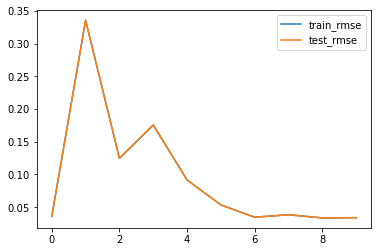

In [10]:
eva_train2, eva_test2 = model_train_test(net_2, 
                                   batchdata_fake, 
                                   batchdata_fake, 
                                   num_epochs =10)
num_epochs = 10
# 绘制图像，查看RMSE变化情况
plt.plot(list(range(num_epochs)), eva_train2[0], label='train_rmse')
plt.plot(list(range(num_epochs)), eva_test2[0], label='test_rmse')
plt.legend(loc = 1) #label摆放位置

In [11]:
eva_train2[0]

[0.0360102578997612,
 0.3355616629123688,
 0.12462987005710602,
 0.17554974555969238,
 0.09156451374292374,
 0.05345171317458153,
 0.03467665985226631,
 0.03839099034667015,
 0.03358199819922447,
 0.033924758434295654]

In [12]:
eva_train2[2]

[0.027167772874236107,
 0.3003964126110077,
 0.09924773871898651,
 0.1444721221923828,
 0.07982565462589264,
 0.04356909915804863,
 0.018998071551322937,
 0.02100420743227005,
 0.014897788874804974,
 0.01544769387692213]

In [13]:
eva_train2[3]

[0.9999993443489075,
 0.9999415874481201,
 0.9999919533729553,
 0.9999840259552002,
 0.9999956488609314,
 0.9999985098838806,
 0.9999994039535522,
 0.9999992251396179,
 0.9999994039535522,
 0.9999994039535522]

In [9]:
#再训练real_data
starttime = datetime.datetime.now()

for i in range(150):
    fit_1(net_2, batchdata_train_real, epochs = 20)

endtime = datetime.datetime.now()
print(endtime - starttime)

tensor(1036.6646, grad_fn=<MseLossBackward0>)
tensor(165.7297, grad_fn=<MseLossBackward0>)
tensor(219.7363, grad_fn=<MseLossBackward0>)
tensor(255.6058, grad_fn=<MseLossBackward0>)
tensor(256.6494, grad_fn=<MseLossBackward0>)
tensor(62.1732, grad_fn=<MseLossBackward0>)
tensor(92.5599, grad_fn=<MseLossBackward0>)
tensor(56.4727, grad_fn=<MseLossBackward0>)
tensor(133.0188, grad_fn=<MseLossBackward0>)
tensor(138.0384, grad_fn=<MseLossBackward0>)
tensor(44.3246, grad_fn=<MseLossBackward0>)
tensor(49.1516, grad_fn=<MseLossBackward0>)
tensor(55.6177, grad_fn=<MseLossBackward0>)
tensor(55.6450, grad_fn=<MseLossBackward0>)
tensor(61.1272, grad_fn=<MseLossBackward0>)
tensor(60.6803, grad_fn=<MseLossBackward0>)
tensor(39.1051, grad_fn=<MseLossBackward0>)
tensor(55.1671, grad_fn=<MseLossBackward0>)
tensor(43.8009, grad_fn=<MseLossBackward0>)
tensor(58.9524, grad_fn=<MseLossBackward0>)
tensor(57.3639, grad_fn=<MseLossBackward0>)
tensor(42.2016, grad_fn=<MseLossBackward0>)
tensor(46.7181, grad_fn=

tensor(26.4803, grad_fn=<MseLossBackward0>)
tensor(45.3104, grad_fn=<MseLossBackward0>)
tensor(11.1254, grad_fn=<MseLossBackward0>)
tensor(14.3339, grad_fn=<MseLossBackward0>)
tensor(11.7089, grad_fn=<MseLossBackward0>)
tensor(14.3926, grad_fn=<MseLossBackward0>)
tensor(43.1373, grad_fn=<MseLossBackward0>)
tensor(11.6574, grad_fn=<MseLossBackward0>)
tensor(19.0424, grad_fn=<MseLossBackward0>)
tensor(33.4506, grad_fn=<MseLossBackward0>)
tensor(10.7424, grad_fn=<MseLossBackward0>)
tensor(64.7214, grad_fn=<MseLossBackward0>)
tensor(28.0662, grad_fn=<MseLossBackward0>)
tensor(39.9526, grad_fn=<MseLossBackward0>)
tensor(22.9102, grad_fn=<MseLossBackward0>)
tensor(10.1435, grad_fn=<MseLossBackward0>)
tensor(27.4193, grad_fn=<MseLossBackward0>)
tensor(12.0381, grad_fn=<MseLossBackward0>)
tensor(8.8503, grad_fn=<MseLossBackward0>)
tensor(17.6431, grad_fn=<MseLossBackward0>)
tensor(9.6876, grad_fn=<MseLossBackward0>)
tensor(18.2289, grad_fn=<MseLossBackward0>)
tensor(51.7389, grad_fn=<MseLossBa

tensor(25.8283, grad_fn=<MseLossBackward0>)
tensor(28.8783, grad_fn=<MseLossBackward0>)
tensor(11.9907, grad_fn=<MseLossBackward0>)
tensor(11.9751, grad_fn=<MseLossBackward0>)
tensor(9.5667, grad_fn=<MseLossBackward0>)
tensor(31.0561, grad_fn=<MseLossBackward0>)
tensor(21.2517, grad_fn=<MseLossBackward0>)
tensor(14.8273, grad_fn=<MseLossBackward0>)
tensor(11.6908, grad_fn=<MseLossBackward0>)
tensor(34.7351, grad_fn=<MseLossBackward0>)
tensor(23.7293, grad_fn=<MseLossBackward0>)
tensor(6.2218, grad_fn=<MseLossBackward0>)
tensor(31.3298, grad_fn=<MseLossBackward0>)
tensor(19.6003, grad_fn=<MseLossBackward0>)
tensor(12.4107, grad_fn=<MseLossBackward0>)
tensor(12.1595, grad_fn=<MseLossBackward0>)
tensor(33.8230, grad_fn=<MseLossBackward0>)
tensor(12.7578, grad_fn=<MseLossBackward0>)
tensor(22.0799, grad_fn=<MseLossBackward0>)
tensor(27.9974, grad_fn=<MseLossBackward0>)
tensor(14.9949, grad_fn=<MseLossBackward0>)
tensor(27.7194, grad_fn=<MseLossBackward0>)
tensor(25.7452, grad_fn=<MseLossBa

tensor(8.1602, grad_fn=<MseLossBackward0>)
tensor(6.2232, grad_fn=<MseLossBackward0>)
tensor(10.6328, grad_fn=<MseLossBackward0>)
tensor(3.3914, grad_fn=<MseLossBackward0>)
tensor(5.7402, grad_fn=<MseLossBackward0>)
tensor(5.1399, grad_fn=<MseLossBackward0>)
tensor(8.1070, grad_fn=<MseLossBackward0>)
tensor(7.3863, grad_fn=<MseLossBackward0>)
tensor(22.8094, grad_fn=<MseLossBackward0>)
tensor(10.2580, grad_fn=<MseLossBackward0>)
tensor(6.0730, grad_fn=<MseLossBackward0>)
tensor(5.6705, grad_fn=<MseLossBackward0>)
tensor(8.7160, grad_fn=<MseLossBackward0>)
tensor(11.6778, grad_fn=<MseLossBackward0>)
tensor(4.3713, grad_fn=<MseLossBackward0>)
tensor(11.7496, grad_fn=<MseLossBackward0>)
tensor(11.4564, grad_fn=<MseLossBackward0>)
tensor(5.5039, grad_fn=<MseLossBackward0>)
tensor(2.9594, grad_fn=<MseLossBackward0>)
tensor(5.4137, grad_fn=<MseLossBackward0>)
tensor(9.9759, grad_fn=<MseLossBackward0>)
tensor(9.9405, grad_fn=<MseLossBackward0>)
tensor(8.8851, grad_fn=<MseLossBackward0>)
tenso

tensor(1.6018, grad_fn=<MseLossBackward0>)
tensor(1.4409, grad_fn=<MseLossBackward0>)
tensor(1.2282, grad_fn=<MseLossBackward0>)
tensor(0.9807, grad_fn=<MseLossBackward0>)
tensor(0.7166, grad_fn=<MseLossBackward0>)
tensor(1.1791, grad_fn=<MseLossBackward0>)
tensor(4.8005, grad_fn=<MseLossBackward0>)
tensor(4.2683, grad_fn=<MseLossBackward0>)
tensor(1.2610, grad_fn=<MseLossBackward0>)
tensor(1.5054, grad_fn=<MseLossBackward0>)
tensor(1.2741, grad_fn=<MseLossBackward0>)
tensor(1.0442, grad_fn=<MseLossBackward0>)
tensor(0.8730, grad_fn=<MseLossBackward0>)
tensor(0.2542, grad_fn=<MseLossBackward0>)
tensor(0.8193, grad_fn=<MseLossBackward0>)
tensor(1.0715, grad_fn=<MseLossBackward0>)
tensor(1.0620, grad_fn=<MseLossBackward0>)
tensor(1.0760, grad_fn=<MseLossBackward0>)
tensor(0.6835, grad_fn=<MseLossBackward0>)
tensor(0.8515, grad_fn=<MseLossBackward0>)
tensor(0.4247, grad_fn=<MseLossBackward0>)
tensor(0.8300, grad_fn=<MseLossBackward0>)
tensor(0.8915, grad_fn=<MseLossBackward0>)
tensor(1.38

tensor(0.4573, grad_fn=<MseLossBackward0>)
tensor(0.3202, grad_fn=<MseLossBackward0>)
tensor(0.8217, grad_fn=<MseLossBackward0>)
tensor(0.3760, grad_fn=<MseLossBackward0>)
tensor(0.7450, grad_fn=<MseLossBackward0>)
tensor(0.2163, grad_fn=<MseLossBackward0>)
tensor(0.3565, grad_fn=<MseLossBackward0>)
tensor(0.4676, grad_fn=<MseLossBackward0>)
tensor(0.6800, grad_fn=<MseLossBackward0>)
tensor(0.4050, grad_fn=<MseLossBackward0>)
tensor(7.6273, grad_fn=<MseLossBackward0>)
tensor(0.8824, grad_fn=<MseLossBackward0>)
tensor(0.3896, grad_fn=<MseLossBackward0>)
tensor(0.5742, grad_fn=<MseLossBackward0>)
tensor(0.3880, grad_fn=<MseLossBackward0>)
tensor(0.2157, grad_fn=<MseLossBackward0>)
tensor(0.2771, grad_fn=<MseLossBackward0>)
tensor(0.2573, grad_fn=<MseLossBackward0>)
tensor(0.3625, grad_fn=<MseLossBackward0>)
tensor(0.2083, grad_fn=<MseLossBackward0>)
tensor(0.6260, grad_fn=<MseLossBackward0>)
tensor(0.4128, grad_fn=<MseLossBackward0>)
tensor(0.3587, grad_fn=<MseLossBackward0>)
tensor(0.29

tensor(0.2292, grad_fn=<MseLossBackward0>)
tensor(0.1769, grad_fn=<MseLossBackward0>)
tensor(0.2022, grad_fn=<MseLossBackward0>)
tensor(0.2049, grad_fn=<MseLossBackward0>)
tensor(0.2187, grad_fn=<MseLossBackward0>)
tensor(0.1787, grad_fn=<MseLossBackward0>)
tensor(0.0893, grad_fn=<MseLossBackward0>)
tensor(0.2272, grad_fn=<MseLossBackward0>)
tensor(0.2990, grad_fn=<MseLossBackward0>)
tensor(0.1131, grad_fn=<MseLossBackward0>)
tensor(5.7595, grad_fn=<MseLossBackward0>)
tensor(0.8603, grad_fn=<MseLossBackward0>)
tensor(0.2829, grad_fn=<MseLossBackward0>)
tensor(0.0982, grad_fn=<MseLossBackward0>)
tensor(0.2123, grad_fn=<MseLossBackward0>)
tensor(0.2629, grad_fn=<MseLossBackward0>)
tensor(0.1037, grad_fn=<MseLossBackward0>)
tensor(0.1519, grad_fn=<MseLossBackward0>)
tensor(0.3137, grad_fn=<MseLossBackward0>)
tensor(0.1461, grad_fn=<MseLossBackward0>)
tensor(0.1905, grad_fn=<MseLossBackward0>)
tensor(0.1037, grad_fn=<MseLossBackward0>)
tensor(0.1065, grad_fn=<MseLossBackward0>)
tensor(0.22

tensor(0.2773, grad_fn=<MseLossBackward0>)
tensor(0.1250, grad_fn=<MseLossBackward0>)
tensor(0.6951, grad_fn=<MseLossBackward0>)
tensor(0.0468, grad_fn=<MseLossBackward0>)
tensor(0.1015, grad_fn=<MseLossBackward0>)
tensor(0.2504, grad_fn=<MseLossBackward0>)
tensor(0.1293, grad_fn=<MseLossBackward0>)
tensor(0.0959, grad_fn=<MseLossBackward0>)
tensor(0.2031, grad_fn=<MseLossBackward0>)
tensor(0.2344, grad_fn=<MseLossBackward0>)
tensor(27.2818, grad_fn=<MseLossBackward0>)
tensor(0.9057, grad_fn=<MseLossBackward0>)
tensor(1.1688, grad_fn=<MseLossBackward0>)
tensor(0.1038, grad_fn=<MseLossBackward0>)
tensor(0.1689, grad_fn=<MseLossBackward0>)
tensor(0.1913, grad_fn=<MseLossBackward0>)
tensor(0.1872, grad_fn=<MseLossBackward0>)
tensor(0.2239, grad_fn=<MseLossBackward0>)
tensor(0.0654, grad_fn=<MseLossBackward0>)
tensor(0.0966, grad_fn=<MseLossBackward0>)
tensor(0.1322, grad_fn=<MseLossBackward0>)
tensor(0.1708, grad_fn=<MseLossBackward0>)
tensor(0.0679, grad_fn=<MseLossBackward0>)
tensor(0.0

tensor(4.8577, grad_fn=<MseLossBackward0>)
tensor(1.3787, grad_fn=<MseLossBackward0>)
tensor(0.2069, grad_fn=<MseLossBackward0>)
tensor(0.2135, grad_fn=<MseLossBackward0>)
tensor(0.1053, grad_fn=<MseLossBackward0>)
tensor(0.1068, grad_fn=<MseLossBackward0>)
tensor(0.1136, grad_fn=<MseLossBackward0>)
tensor(0.1359, grad_fn=<MseLossBackward0>)
tensor(0.2882, grad_fn=<MseLossBackward0>)
tensor(0.0888, grad_fn=<MseLossBackward0>)
tensor(0.2043, grad_fn=<MseLossBackward0>)
tensor(0.2212, grad_fn=<MseLossBackward0>)
tensor(0.1376, grad_fn=<MseLossBackward0>)
tensor(0.2759, grad_fn=<MseLossBackward0>)
tensor(0.1010, grad_fn=<MseLossBackward0>)
tensor(0.0925, grad_fn=<MseLossBackward0>)
tensor(0.0988, grad_fn=<MseLossBackward0>)
tensor(0.1117, grad_fn=<MseLossBackward0>)
tensor(0.1016, grad_fn=<MseLossBackward0>)
tensor(16.3713, grad_fn=<MseLossBackward0>)
tensor(1.0186, grad_fn=<MseLossBackward0>)
tensor(0.6750, grad_fn=<MseLossBackward0>)
tensor(0.1521, grad_fn=<MseLossBackward0>)
tensor(0.1

tensor(0.1791, grad_fn=<MseLossBackward0>)
tensor(0.1085, grad_fn=<MseLossBackward0>)
tensor(0.0902, grad_fn=<MseLossBackward0>)
tensor(4.1370, grad_fn=<MseLossBackward0>)
tensor(1.6227, grad_fn=<MseLossBackward0>)
tensor(0.2842, grad_fn=<MseLossBackward0>)
tensor(0.0867, grad_fn=<MseLossBackward0>)
tensor(0.1027, grad_fn=<MseLossBackward0>)
tensor(0.0985, grad_fn=<MseLossBackward0>)
tensor(0.1089, grad_fn=<MseLossBackward0>)
tensor(0.2540, grad_fn=<MseLossBackward0>)
tensor(0.1595, grad_fn=<MseLossBackward0>)
tensor(0.3212, grad_fn=<MseLossBackward0>)
tensor(0.0430, grad_fn=<MseLossBackward0>)
tensor(0.0597, grad_fn=<MseLossBackward0>)
tensor(0.1900, grad_fn=<MseLossBackward0>)
tensor(0.1226, grad_fn=<MseLossBackward0>)
tensor(0.2136, grad_fn=<MseLossBackward0>)
tensor(0.0915, grad_fn=<MseLossBackward0>)
tensor(0.2203, grad_fn=<MseLossBackward0>)
tensor(0.1638, grad_fn=<MseLossBackward0>)
tensor(0.6552, grad_fn=<MseLossBackward0>)
tensor(0.1291, grad_fn=<MseLossBackward0>)
tensor(7.02

tensor(0.1101, grad_fn=<MseLossBackward0>)
tensor(0.1712, grad_fn=<MseLossBackward0>)
tensor(0.0925, grad_fn=<MseLossBackward0>)
tensor(0.2194, grad_fn=<MseLossBackward0>)
tensor(0.0770, grad_fn=<MseLossBackward0>)
tensor(0.1745, grad_fn=<MseLossBackward0>)
tensor(0.1427, grad_fn=<MseLossBackward0>)
tensor(0.1184, grad_fn=<MseLossBackward0>)
tensor(0.0723, grad_fn=<MseLossBackward0>)
tensor(1.1967, grad_fn=<MseLossBackward0>)
tensor(0.8544, grad_fn=<MseLossBackward0>)
tensor(0.2608, grad_fn=<MseLossBackward0>)
tensor(0.1954, grad_fn=<MseLossBackward0>)
tensor(0.1937, grad_fn=<MseLossBackward0>)
tensor(0.0946, grad_fn=<MseLossBackward0>)
tensor(0.3122, grad_fn=<MseLossBackward0>)
tensor(0.1397, grad_fn=<MseLossBackward0>)
tensor(0.0892, grad_fn=<MseLossBackward0>)
tensor(0.1193, grad_fn=<MseLossBackward0>)
tensor(0.0892, grad_fn=<MseLossBackward0>)
tensor(0.1168, grad_fn=<MseLossBackward0>)
tensor(0.2126, grad_fn=<MseLossBackward0>)
tensor(0.0632, grad_fn=<MseLossBackward0>)
tensor(0.10

tensor(0.9295, grad_fn=<MseLossBackward0>)
tensor(0.1026, grad_fn=<MseLossBackward0>)
tensor(0.1106, grad_fn=<MseLossBackward0>)
tensor(0.0654, grad_fn=<MseLossBackward0>)
tensor(0.1245, grad_fn=<MseLossBackward0>)
tensor(0.1437, grad_fn=<MseLossBackward0>)
tensor(0.6154, grad_fn=<MseLossBackward0>)
tensor(0.0751, grad_fn=<MseLossBackward0>)
tensor(0.0716, grad_fn=<MseLossBackward0>)
tensor(0.0852, grad_fn=<MseLossBackward0>)
tensor(0.1575, grad_fn=<MseLossBackward0>)
tensor(0.0690, grad_fn=<MseLossBackward0>)
tensor(0.0837, grad_fn=<MseLossBackward0>)
tensor(0.0661, grad_fn=<MseLossBackward0>)
tensor(0.0406, grad_fn=<MseLossBackward0>)
tensor(0.2075, grad_fn=<MseLossBackward0>)
tensor(0.0864, grad_fn=<MseLossBackward0>)
tensor(0.0420, grad_fn=<MseLossBackward0>)
tensor(4.6164, grad_fn=<MseLossBackward0>)
tensor(1.1193, grad_fn=<MseLossBackward0>)
tensor(1.1024, grad_fn=<MseLossBackward0>)
tensor(0.2604, grad_fn=<MseLossBackward0>)
tensor(0.1026, grad_fn=<MseLossBackward0>)
tensor(0.04

tensor(0.0884, grad_fn=<MseLossBackward0>)
tensor(0.1762, grad_fn=<MseLossBackward0>)
tensor(0.0552, grad_fn=<MseLossBackward0>)
tensor(0.0836, grad_fn=<MseLossBackward0>)
tensor(0.0938, grad_fn=<MseLossBackward0>)
tensor(0.0783, grad_fn=<MseLossBackward0>)
tensor(0.1258, grad_fn=<MseLossBackward0>)
tensor(19.0099, grad_fn=<MseLossBackward0>)
tensor(2.1083, grad_fn=<MseLossBackward0>)
tensor(0.3533, grad_fn=<MseLossBackward0>)
tensor(0.1207, grad_fn=<MseLossBackward0>)
tensor(0.2164, grad_fn=<MseLossBackward0>)
tensor(0.1522, grad_fn=<MseLossBackward0>)
tensor(0.0435, grad_fn=<MseLossBackward0>)
tensor(0.1095, grad_fn=<MseLossBackward0>)
tensor(0.0902, grad_fn=<MseLossBackward0>)
tensor(0.0693, grad_fn=<MseLossBackward0>)
tensor(0.2337, grad_fn=<MseLossBackward0>)
tensor(0.0964, grad_fn=<MseLossBackward0>)
tensor(0.0663, grad_fn=<MseLossBackward0>)
tensor(0.1845, grad_fn=<MseLossBackward0>)
tensor(0.0718, grad_fn=<MseLossBackward0>)
tensor(0.0714, grad_fn=<MseLossBackward0>)
tensor(0.1

tensor(0.0439, grad_fn=<MseLossBackward0>)
tensor(0.1795, grad_fn=<MseLossBackward0>)
tensor(0.1236, grad_fn=<MseLossBackward0>)
tensor(0.1496, grad_fn=<MseLossBackward0>)
tensor(0.1071, grad_fn=<MseLossBackward0>)
tensor(0.5605, grad_fn=<MseLossBackward0>)
tensor(16.6242, grad_fn=<MseLossBackward0>)
tensor(0.3855, grad_fn=<MseLossBackward0>)
tensor(0.5711, grad_fn=<MseLossBackward0>)
tensor(0.4541, grad_fn=<MseLossBackward0>)
tensor(0.0837, grad_fn=<MseLossBackward0>)
tensor(0.1092, grad_fn=<MseLossBackward0>)
tensor(0.2133, grad_fn=<MseLossBackward0>)
tensor(0.0702, grad_fn=<MseLossBackward0>)
tensor(0.1210, grad_fn=<MseLossBackward0>)
tensor(0.1466, grad_fn=<MseLossBackward0>)
tensor(0.2369, grad_fn=<MseLossBackward0>)
tensor(0.0566, grad_fn=<MseLossBackward0>)
tensor(0.0834, grad_fn=<MseLossBackward0>)
tensor(0.0883, grad_fn=<MseLossBackward0>)
tensor(0.0684, grad_fn=<MseLossBackward0>)
tensor(0.2885, grad_fn=<MseLossBackward0>)
tensor(0.0332, grad_fn=<MseLossBackward0>)
tensor(0.0

tensor(0.0844, grad_fn=<MseLossBackward0>)
tensor(0.0393, grad_fn=<MseLossBackward0>)
tensor(0.0589, grad_fn=<MseLossBackward0>)
tensor(0.1544, grad_fn=<MseLossBackward0>)
tensor(0.0475, grad_fn=<MseLossBackward0>)
tensor(0.0451, grad_fn=<MseLossBackward0>)
tensor(0.0907, grad_fn=<MseLossBackward0>)
tensor(0.0645, grad_fn=<MseLossBackward0>)
tensor(0.3417, grad_fn=<MseLossBackward0>)
tensor(0.1016, grad_fn=<MseLossBackward0>)
tensor(7.6677, grad_fn=<MseLossBackward0>)
tensor(2.0799, grad_fn=<MseLossBackward0>)
tensor(1.6449, grad_fn=<MseLossBackward0>)
tensor(0.1611, grad_fn=<MseLossBackward0>)
tensor(0.0579, grad_fn=<MseLossBackward0>)
tensor(0.0670, grad_fn=<MseLossBackward0>)
tensor(0.1938, grad_fn=<MseLossBackward0>)
tensor(0.1265, grad_fn=<MseLossBackward0>)
tensor(0.0951, grad_fn=<MseLossBackward0>)
tensor(0.0862, grad_fn=<MseLossBackward0>)
tensor(0.1217, grad_fn=<MseLossBackward0>)
tensor(0.0942, grad_fn=<MseLossBackward0>)
tensor(0.0735, grad_fn=<MseLossBackward0>)
tensor(0.15

tensor(0.1583, grad_fn=<MseLossBackward0>)
tensor(0.0416, grad_fn=<MseLossBackward0>)
tensor(0.1332, grad_fn=<MseLossBackward0>)
tensor(0.1303, grad_fn=<MseLossBackward0>)
tensor(0.0425, grad_fn=<MseLossBackward0>)
tensor(0.1423, grad_fn=<MseLossBackward0>)
tensor(0.2304, grad_fn=<MseLossBackward0>)
tensor(0.1053, grad_fn=<MseLossBackward0>)
tensor(0.0347, grad_fn=<MseLossBackward0>)
tensor(0.3195, grad_fn=<MseLossBackward0>)
tensor(0.3214, grad_fn=<MseLossBackward0>)
tensor(1.1018, grad_fn=<MseLossBackward0>)
tensor(0.3576, grad_fn=<MseLossBackward0>)
tensor(0.1005, grad_fn=<MseLossBackward0>)
tensor(0.0840, grad_fn=<MseLossBackward0>)
tensor(0.0715, grad_fn=<MseLossBackward0>)
tensor(0.1728, grad_fn=<MseLossBackward0>)
tensor(0.0531, grad_fn=<MseLossBackward0>)
tensor(0.1054, grad_fn=<MseLossBackward0>)
tensor(0.1235, grad_fn=<MseLossBackward0>)
tensor(0.0931, grad_fn=<MseLossBackward0>)
tensor(0.0547, grad_fn=<MseLossBackward0>)
tensor(0.0564, grad_fn=<MseLossBackward0>)
tensor(0.10

tensor(13.1877, grad_fn=<MseLossBackward0>)
tensor(1.3731, grad_fn=<MseLossBackward0>)
tensor(0.6229, grad_fn=<MseLossBackward0>)
tensor(3.8432, grad_fn=<MseLossBackward0>)
tensor(2.7540, grad_fn=<MseLossBackward0>)
tensor(0.8318, grad_fn=<MseLossBackward0>)
tensor(8.1113, grad_fn=<MseLossBackward0>)
tensor(0.4314, grad_fn=<MseLossBackward0>)
tensor(0.6717, grad_fn=<MseLossBackward0>)
tensor(0.1915, grad_fn=<MseLossBackward0>)
tensor(4.6052, grad_fn=<MseLossBackward0>)
tensor(7.6575, grad_fn=<MseLossBackward0>)
tensor(1.2910, grad_fn=<MseLossBackward0>)
tensor(0.2769, grad_fn=<MseLossBackward0>)
tensor(0.3298, grad_fn=<MseLossBackward0>)
tensor(9.9207, grad_fn=<MseLossBackward0>)
tensor(0.5482, grad_fn=<MseLossBackward0>)
tensor(0.5915, grad_fn=<MseLossBackward0>)
tensor(0.1350, grad_fn=<MseLossBackward0>)
tensor(0.1631, grad_fn=<MseLossBackward0>)
tensor(0.1508, grad_fn=<MseLossBackward0>)
tensor(7.8209, grad_fn=<MseLossBackward0>)
tensor(3.9240, grad_fn=<MseLossBackward0>)
tensor(0.7

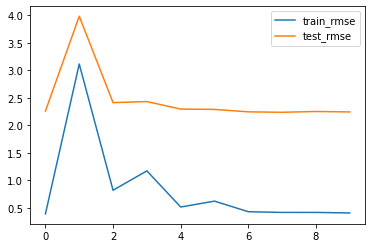

In [11]:
eva_train1, eva_test1= model_train_test(net_1, 
                                   batchdata_train_real, 
                                   batchdata_test_real, 
                                   num_epochs =10)
num_epochs = 10
# 绘制图像，查看RMSE变化情况
plt.plot(list(range(num_epochs)), eva_train1[0], label='train_rmse')
plt.plot(list(range(num_epochs)), eva_test1[0], label='test_rmse')
plt.legend(loc = 1) #label摆放位置

In [27]:
eva_train1[0]

[0.38711580634117126,
 3.115259885787964,
 0.8178685903549194,
 1.1702790260314941,
 0.512685239315033,
 0.6198475360870361,
 0.42713961005210876,
 0.41441482305526733,
 0.4142247140407562,
 0.4045317769050598]

In [13]:
eva_test1[0]

[2.256953001022339,
 3.9843757152557373,
 2.4127304553985596,
 2.431576728820801,
 2.2953271865844727,
 2.2887680530548096,
 2.245056390762329,
 2.2366812229156494,
 2.251091241836548,
 2.242888927459717]

In [28]:
eva_train1[2]

[0.2747953236103058,
 2.764988899230957,
 0.6379219889640808,
 0.9880998134613037,
 0.39272797107696533,
 0.49912917613983154,
 0.33773988485336304,
 0.3289896249771118,
 0.3127136826515198,
 0.31130343675613403]

In [14]:
eva_test1[2]

[0.4732057452201843,
 2.979154109954834,
 0.8398679494857788,
 1.190894603729248,
 0.5752071142196655,
 0.658068060874939,
 0.5208448171615601,
 0.5200911164283752,
 0.5091676712036133,
 0.5020888447761536]

In [15]:
eva_test1[3]

[0.9972687363624573,
 0.9914878010749817,
 0.9968786835670471,
 0.9968297481536865,
 0.9971750378608704,
 0.9971911907196045,
 0.997297465801239,
 0.9973175525665283,
 0.9972829222679138,
 0.9973026514053345]

tensor(8.9964, grad_fn=<MseLossBackward0>)
tensor(8.7101, grad_fn=<MseLossBackward0>)
tensor(2.2681, grad_fn=<MseLossBackward0>)
tensor(10.2581, grad_fn=<MseLossBackward0>)
tensor(0.1671, grad_fn=<MseLossBackward0>)
tensor(1.0222, grad_fn=<MseLossBackward0>)
tensor(8.2479, grad_fn=<MseLossBackward0>)
tensor(0.4185, grad_fn=<MseLossBackward0>)
tensor(0.1504, grad_fn=<MseLossBackward0>)
tensor(0.0826, grad_fn=<MseLossBackward0>)
tensor(0.9653, grad_fn=<MseLossBackward0>)
tensor(4.4736, grad_fn=<MseLossBackward0>)
tensor(1.0286, grad_fn=<MseLossBackward0>)
tensor(0.2378, grad_fn=<MseLossBackward0>)
tensor(0.6710, grad_fn=<MseLossBackward0>)
tensor(6.4428, grad_fn=<MseLossBackward0>)
tensor(2.2167, grad_fn=<MseLossBackward0>)
tensor(0.1984, grad_fn=<MseLossBackward0>)
tensor(0.0910, grad_fn=<MseLossBackward0>)
tensor(0.1595, grad_fn=<MseLossBackward0>)
tensor(0.1488, grad_fn=<MseLossBackward0>)
tensor(9.2038, grad_fn=<MseLossBackward0>)
tensor(0.3954, grad_fn=<MseLossBackward0>)
tensor(0.6

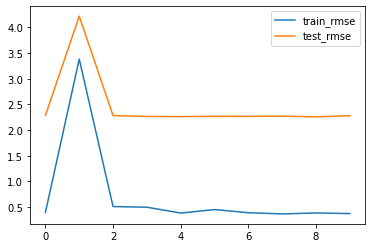

In [16]:
eva_train2, eva_test2 = model_train_test(net_2, 
                                   batchdata_train_real, 
                                   batchdata_test_real, 
                                   num_epochs =10)
num_epochs = 10
# 绘制图像，查看RMSE变化情况
plt.plot(list(range(num_epochs)), eva_train2[0], label='train_rmse')
plt.plot(list(range(num_epochs)), eva_test2[0], label='test_rmse')
plt.legend(loc = 1) #label摆放位置

In [17]:
eva_train2[2]

[0.2781389057636261,
 3.0180914402008057,
 0.39347854256629944,
 0.38732603192329407,
 0.2858094573020935,
 0.3351270854473114,
 0.2875128388404846,
 0.263574481010437,
 0.3002820312976837,
 0.2726852595806122]

In [18]:
eva_test2[0]

[2.2852072715759277,
 4.217215538024902,
 2.2810235023498535,
 2.264179229736328,
 2.2611680030822754,
 2.2677972316741943,
 2.2659077644348145,
 2.270660638809204,
 2.2568540573120117,
 2.2785351276397705]

In [19]:
eva_test2[2]

[0.4893271327018738,
 3.226245164871216,
 0.5749028325080872,
 0.582658588886261,
 0.48850786685943604,
 0.5215457677841187,
 0.49271270632743835,
 0.4813981354236603,
 0.53824782371521,
 0.49074870347976685]

In [20]:
eva_test2[3]

[0.9971998929977417,
 0.9904638528823853,
 0.9972101449966431,
 0.9972512125968933,
 0.9972585439682007,
 0.9972423911094666,
 0.9972469806671143,
 0.9972354769706726,
 0.9972689747810364,
 0.9972162246704102]

In [10]:
def y_test(data_loader, net):
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    return y

def yhat_test(data_loader, net):
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    return yhat

def test_data(model, 
              train_data,
              test_data,
              num_epochs = 10):
    y_test_list = []
    yhat_test_list = []
    for epochs in range(num_epochs):
        model.train()
        fit_1(net = model,
            batchdata = train_data, 
            epochs = epochs)
        model.eval()
        y_test_list.append(y_test(test_data, model))
        yhat_test_list.append(yhat_test(test_data, model))

    return y_test_list, yhat_test_list

In [22]:
y_test_list_1,yhat_test_list_1 = test_data(net_1, 
                            batchdata_train_real, 
                            batchdata_test_real, 
                            num_epochs = 10)

tensor(8.6894, grad_fn=<MseLossBackward0>)
tensor(1.0126, grad_fn=<MseLossBackward0>)
tensor(0.5291, grad_fn=<MseLossBackward0>)
tensor(12.7594, grad_fn=<MseLossBackward0>)
tensor(1.2217, grad_fn=<MseLossBackward0>)
tensor(0.4510, grad_fn=<MseLossBackward0>)
tensor(3.8905, grad_fn=<MseLossBackward0>)
tensor(0.5779, grad_fn=<MseLossBackward0>)
tensor(0.1523, grad_fn=<MseLossBackward0>)
tensor(0.1635, grad_fn=<MseLossBackward0>)
tensor(4.4980, grad_fn=<MseLossBackward0>)
tensor(3.3570, grad_fn=<MseLossBackward0>)
tensor(0.6901, grad_fn=<MseLossBackward0>)
tensor(0.3995, grad_fn=<MseLossBackward0>)
tensor(0.1955, grad_fn=<MseLossBackward0>)
tensor(3.4199, grad_fn=<MseLossBackward0>)
tensor(3.2704, grad_fn=<MseLossBackward0>)
tensor(1.3253, grad_fn=<MseLossBackward0>)
tensor(0.1975, grad_fn=<MseLossBackward0>)
tensor(0.1946, grad_fn=<MseLossBackward0>)
tensor(0.1040, grad_fn=<MseLossBackward0>)
tensor(6.1550, grad_fn=<MseLossBackward0>)
tensor(2.6361, grad_fn=<MseLossBackward0>)
tensor(0.3

In [23]:
test1 = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=y_test_list_1[-1].numpy().reshape(108,3))

test1.to_csv(r"C:\Users\Neos\Desktop\data_real.csv", encoding='gbk')

In [24]:
test2 = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=yhat_test_list_1[-1].detach().numpy().reshape(108,3))

test2.to_csv(r"C:\Users\Neos\Desktop\data_dnn.csv", encoding='gbk')

In [25]:
y_test_list_2,yhat_test_list_2 = test_data(net_2, 
                            batchdata_train_real, 
                            batchdata_test_real, 
                            num_epochs = 10)

tensor(5.8367, grad_fn=<MseLossBackward0>)
tensor(2.1689, grad_fn=<MseLossBackward0>)
tensor(0.2792, grad_fn=<MseLossBackward0>)
tensor(17.6923, grad_fn=<MseLossBackward0>)
tensor(0.3013, grad_fn=<MseLossBackward0>)
tensor(0.3798, grad_fn=<MseLossBackward0>)
tensor(0.2558, grad_fn=<MseLossBackward0>)
tensor(0.9261, grad_fn=<MseLossBackward0>)
tensor(0.2782, grad_fn=<MseLossBackward0>)
tensor(0.1905, grad_fn=<MseLossBackward0>)
tensor(1.4474, grad_fn=<MseLossBackward0>)
tensor(2.2795, grad_fn=<MseLossBackward0>)
tensor(0.2123, grad_fn=<MseLossBackward0>)
tensor(0.1324, grad_fn=<MseLossBackward0>)
tensor(0.1464, grad_fn=<MseLossBackward0>)
tensor(8.5547, grad_fn=<MseLossBackward0>)
tensor(0.3743, grad_fn=<MseLossBackward0>)
tensor(0.2337, grad_fn=<MseLossBackward0>)
tensor(0.1341, grad_fn=<MseLossBackward0>)
tensor(0.2217, grad_fn=<MseLossBackward0>)
tensor(0.0927, grad_fn=<MseLossBackward0>)
tensor(7.3569, grad_fn=<MseLossBackward0>)
tensor(1.3931, grad_fn=<MseLossBackward0>)
tensor(0.1

In [26]:
test3 = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=yhat_test_list_2[-1].detach().numpy().reshape(108,3))

test3.to_csv(r"C:\Users\Neos\Desktop\data_new.csv", encoding='gbk')

In [11]:
y_test_list_fake,yhat_test_list_fake = test_data(net_2, 
                            batchdata_fake, 
                            batchdata_fake, 
                            num_epochs = 10)

tensor(2.2982, grad_fn=<MseLossBackward0>)
tensor(0.4733, grad_fn=<MseLossBackward0>)
tensor(0.1600, grad_fn=<MseLossBackward0>)
tensor(1.9770, grad_fn=<MseLossBackward0>)
tensor(0.0420, grad_fn=<MseLossBackward0>)
tensor(0.0192, grad_fn=<MseLossBackward0>)
tensor(0.6476, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.1188, grad_fn=<MseLossBackward0>)
tensor(0.0102, grad_fn=<MseLossBackward0>)
tensor(0.3507, grad_fn=<MseLossBackward0>)
tensor(0.3050, grad_fn=<MseLossBackward0>)
tensor(0.0064, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(2.0647, grad_fn=<MseLossBackward0>)
tensor(0.2986, grad_fn=<MseLossBackward0>)
tensor(0.0181, grad_fn=<MseLossBackward0>)
tensor(0.0350, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(1.9761, grad_fn=<MseLossBackward0>)
tensor(0.0195, grad_fn=<MseLossBackward0>)
tensor(0.04

In [12]:
testx = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=yhat_test_list_fake[-1].detach().numpy().reshape(540,3))

testx.to_csv(r"C:\Users\Neos\Desktop\DNN.csv", encoding='gbk')